In [1]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
import seaborn as sns
import os 
import pandas_ta as ta 
import time
from datetime import datetime, timedelta
import math
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt 
from transformers import * 
import torch 
from torch import Tensor 
from torch.utils.data import * 
import torch.nn as nn 
import torch.nn.functional as F 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from pytorch_metric_learning import miners, losses
from pytorch_metric_learning.distances import CosineSimilarity
from scipy.spatial.distance import cdist 
import pickle
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [2]:
with open("BTC_USDT-1h-12.json") as f: 
        d = json.load(f) 

chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})

def process(df): 
        binance = ccxt.binance() 
        dates = df["timestamp"].values 
        timestamp = [] 
        for i in range(len(dates)):
                date_string = binance.iso8601(int(dates[i])) 
                date_string = date_string[:10] + " " + date_string[11:-5] 
                timestamp.append(date_string) 
        df["datetime"] = timestamp
        df = df.drop(columns={"timestamp"}) 
        return df 

chart_df = process(chart_df) 

hours, days, months, years = [],[],[],[] 
for dt in tqdm(chart_df["datetime"]):
        dtobj = pd.to_datetime(dt) 
        hour = dtobj.hour 
        day = dtobj.day 
        month = dtobj.month 
        year = dtobj.year 
        hours.append(hour) 
        days.append(day) 
        months.append(month) 
        years.append(year) 

chart_df["hours"] = hours 
chart_df["days"] = days  
chart_df["months"] = months 
chart_df["years"] = years 

  0%|          | 0/47346 [00:00<?, ?it/s]

In [3]:
close = chart_df["close"].values 
datetimes = chart_df["datetime"].values 

anomalous_datetimes = [] 

lookback_window = 12 
forecast_window = 6

threshold = 1 # is 1% considered an anomaly for 1 hour chart data 

for i in range(lookback_window, close.shape[0]-forecast_window):
    cur_close = close[i-lookback_window+1:i+1] 
    delta = (cur_close[-1] - cur_close[-2]) / cur_close[-2] * 100 
    if delta >= threshold or delta <= -threshold:
        dtobj = datetime.strptime(str(datetimes[i]), "%Y-%m-%d %H:%M:%S") 
        anomalous_datetimes.append(dtobj)

In [4]:
# contains all corresponding chart data for the given date 
date_chart_df = {} 

for i in tqdm(range(lookback_window, len(datetimes)-forecast_window)): 
    dtobj = datetime.strptime(str(datetimes[i]), "%Y-%m-%d %H:%M:%S")  
    date_chart_df[dtobj] = (close[i-lookback_window+1:i+1], close[i+1:i+1+forecast_window])

  0%|          | 0/47328 [00:00<?, ?it/s]

In [6]:
labels = [] 
two_high_delta, two_low_delta = [], [] 

for i in tqdm(range(len(anomalous_datetimes)), position=0, leave=True):
    past_input, future_input = date_chart_df[anomalous_datetimes[i]] 
    last_close = past_input[-1] 
    maxhigh, minlow = np.max(future_input), np.min(future_input) 
    high_delta = (maxhigh - last_close) / last_close * 100.0 
    low_delta = (minlow - last_close) / last_close * 100.0 
    if high_delta >= 1.0 or low_delta <= -1.0: 
        if high_delta >= np.abs(low_delta): 
            labels.append(0) 
        elif high_delta < np.abs(low_delta): 
            labels.append(1) 
    else: 
        labels.append(2)  
        two_high_delta.append(high_delta) 
        two_low_delta.append(low_delta)  

  0%|          | 0/6456 [00:00<?, ?it/s]

In [7]:
cntmap = {0:0, 1:0, 2:0} 

for i in range(len(labels)): 
    cntmap[labels[i]] += 1 
    
cntmap

{0: 2756, 1: 2558, 2: 1142}

In [10]:
news = pd.read_csv("full_news_22_01_16.csv")
titles = news["titles"].values 
contents = news["contents"].values 

years = news["year"].values 
months = news["month"].values 
days = news["day"].values 
hours = news["hour"].values 

news_dtobjects = [] 

for i in tqdm(range(len(years)), position=0, leave=True): 
    date_str = str(years[i]) + "-" + str(months[i]) + "-" + str(days[i]) + " " + str(hours[i]) + ":00:00" 
    dtobj = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")  
    news_dtobjects.append(dtobj) 

  0%|          | 0/113954 [00:00<?, ?it/s]

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
tokenizer = AlbertTokenizer.from_pretrained("totoro4007/cryptodeberta-base-all-finetuned") 
model = AutoModelForSequenceClassification.from_pretrained("totoro4007/cryptodeberta-base-all-finetuned", num_labels=3) 
model.to(device)  
model.eval() 
print() 

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--totoro4007--cryptodeberta-base-all-finetuned/snapshots/de08541cefb506b62199f1fb009baec865481fef/spiece.model
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--totoro4007--cryptodeberta-base-all-finetuned/snapshots/de08541cefb506b62199f1fb009baec865481fef/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--totoro4007--cryptodeberta-base-all-finetuned/snapshots/de08541cefb506b62199f1fb009baec865481fef/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--totoro4007--cryptodeberta-base-all-finetuned/snapshots/de08541cefb506b62199f1fb009baec865481fef/tokenizer_config.json
Adding <pad> to the vocabulary
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--totoro4007--cryptodeberta-base-all-finetuned/snapshots/de08541cefb506b62199f1fb009bae

In [13]:
# we cannot consider sections where news data is not available 
searchable = [] # at least have one news for comparison 

for i in tqdm(range(len(anomalous_datetimes)), position=0, leave=True): 
    dtobj = anomalous_datetimes[i] 
    start_dt, end_dt = dtobj-timedelta(hours=12), dtobj 
    cnt = 0 
    for k in range(len(news_dtobjects)): 
        if news_dtobjects[k] >= start_dt and news_dtobjects[k] <= end_dt: 
            cnt += 1
        elif news_dtobjects[k] > end_dt: 
            break 
    if cnt > 0:
        searchable.append((dtobj, cnt))

  0%|          | 0/6456 [00:00<?, ?it/s]

In [14]:
with open("news_score_dict.pkl", "rb") as f: 
    news_score_dict = pickle.load(f) 

In [17]:
def get_score_given_date(d):
    start_dt, end_dt = d-timedelta(hours=12), d 
    score_arr = np.zeros((3)) # positive, negative, neutral 
    for k in range(len(news_dtobjects)): 
        if news_dtobjects[k] >= start_dt and news_dtobjects[k] <= end_dt: 
            score_arr[0] += news_score_dict[titles[k]][0] 
            score_arr[1] += news_score_dict[titles[k]][1] 
            score_arr[2] += news_score_dict[titles[k]][2] 
    return score_arr 

In [28]:
def euclidean_distance(x1, x2): 
    return np.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2 + (x1[2]-x2[2])**2) 

In [60]:
label_dict = {} 
for i in tqdm(range(len(searchable)), position=0, leave=True): 
    cur_date = searchable[i][0]
    past_input, future_input = date_chart_df[cur_date]  
    last_close = past_input[-1] 
    maxhigh, minlow = np.max(future_input), np.min(future_input) 
    high_delta = (maxhigh - last_close) / last_close * 100.0 
    low_delta = (minlow - last_close) / last_close * 100.0  
    if high_delta >= 1.0 or low_delta <= -1.0: 
        if high_delta >= np.abs(low_delta): 
            label_dict[cur_date] = 0 
        elif high_delta < np.abs(low_delta): 
            label_dict[cur_date] = 1 
    else: 
        label_dict[cur_date] = 2 

  0%|          | 0/4247 [00:00<?, ?it/s]

In [62]:
past_input_dir = {} 
for i in tqdm(range(len(searchable)), position=0, leave=True):
    cur_date = searchable[i][0]
    past_input, future_input = date_chart_df[cur_date] 
    delta = (past_input[-1] - past_input[-2]) / past_input[-2] * 100.0 
    if delta >= 1.0: 
        past_input_dir[cur_date] = 0 
    elif delta <= -1.0: 
        past_input_dir[cur_date] = 1 

  0%|          | 0/4247 [00:00<?, ?it/s]

In [ ]:
similarity_dict = {} 

topK = 3
for i in tqdm(range(100, len(searchable)), position=0, leave=True): 
    query_date = searchable[i][0]  
    query_direction = past_input_dir[query_date] 
    query_score = get_score_given_date(query_date) 
    candidate_info = [] 
    for j in range(0, i):
        candidate_date = searchable[j][0] 
        candidate_score = get_score_given_date(candidate_date) 
        distance = euclidean_distance(query_score, candidate_score) 
        candidate_info.append((candidate_date, distance)) 
    
    candidate_info = sorted(candidate_info, key=lambda x: x[1]) # sort accoding to euclidean distance in ascending order 
    relevant_candidates = [] 
    cnt = 0 
    for j in range(len(candidate_info)): 
        if cnt == topK: 
            break 
        candidate_date, candidate_distance = candidate_info[j][0], candidate_info[j][1] 
        candidate_direction = past_input_dir[candidate_date] 
        if query_direction == candidate_direction:
            relevant_candidates.append(candidate_date) 
            cnt += 1 
            
    similarity_dict[query_date] = relevant_candidates 


  0%|          | 0/4147 [00:00<?, ?it/s]

In [ ]:
with open("similarity_dict.pkl", "wb") as f: 
    pickle.dump(similarity_dict, f)
    
print("done saving!") 

### print a few samples

In [65]:
similarity_dict

{datetime.datetime(2018, 2, 13, 21, 0): [datetime.datetime(2018, 2, 2, 17, 0),
  datetime.datetime(2018, 2, 5, 17, 0),
  datetime.datetime(2018, 2, 5, 18, 0)]}

query label : 0


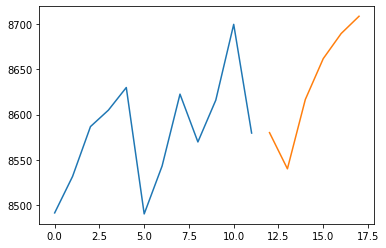

candidate label : 0


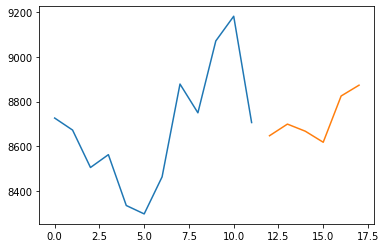

candidate label : 1


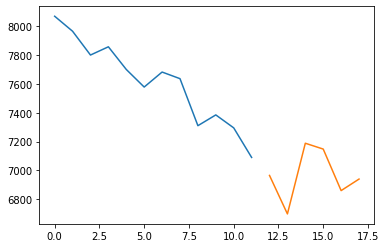

candidate label : 1


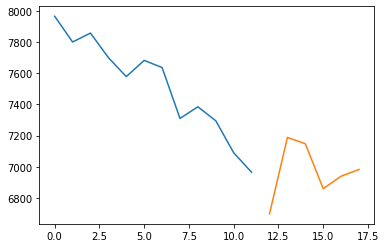

In [69]:
for key, value in similarity_dict.items(): 
    query_date = key 
    candidate_dates = value 
    
    print(f"query label : {label_dict[query_date]}") 
    x1, x2 = date_chart_df[query_date] 
    plt.plot(np.arange(12), x1)
    plt.plot(np.arange(12, 12+6), x2) 
    plt.show() 
    
    for i in range(len(candidate_dates)): 
        print(f"candidate label : {label_dict[candidate_dates[i]]}") 
        x1, x2 = date_chart_df[candidate_dates[i]] 
        plt.plot(np.arange(12), x1)
        plt.plot(np.arange(12, 12+6), x2) 
        plt.show() 
    

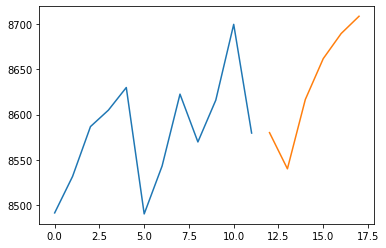

In [50]:
x1, x2 = date_chart_df[query_date]

plt.plot(np.arange(12), x1)
plt.plot(np.arange(12, 12+6), x2) 

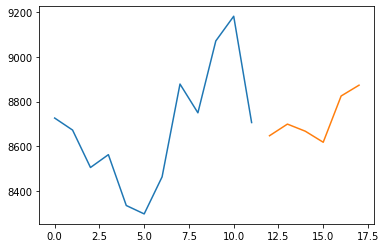

In [52]:
x1, x2 = date_chart_df[candidate_info[0][0]]

plt.plot(np.arange(12), x1)
plt.plot(np.arange(12, 12+6), x2) 

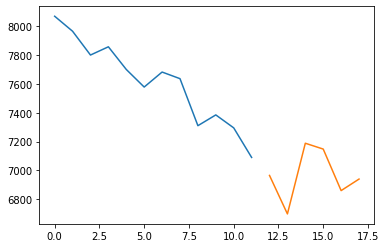

In [53]:
x1, x2 = date_chart_df[candidate_info[1][0]]

plt.plot(np.arange(12), x1)
plt.plot(np.arange(12, 12+6), x2) 

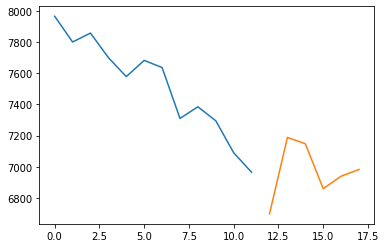

In [54]:
x1, x2 = date_chart_df[candidate_info[2][0]]

plt.plot(np.arange(12), x1)
plt.plot(np.arange(12, 12+6), x2) 

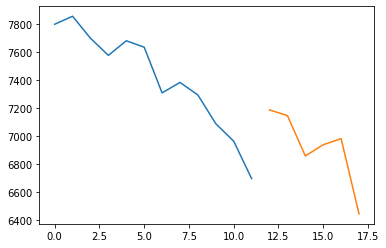

In [55]:
x1, x2 = date_chart_df[candidate_info[3][0]]

plt.plot(np.arange(12), x1)
plt.plot(np.arange(12, 12+6), x2) 